# Inpainting with homogeneous diffusion 
We will use the inpainting with Homogeneous diffusion to interpolate in a grid. The method is described in https://arxiv.org/pdf/1506.04566.pdf. We consider the following PDE with mixed boundary conditions
$$\begin{align}
\nabla u &= 0 \text{ on } \Omega \setminus \Omega_{K}\,, \\
u &= f  \text{ on } \Omega_K \,, \\
\partial_n u &= 0 \text{ on } \partial \Omega \setminus \partial \Omega_K\,.
\end{align}$$

Here $ \partial_n u $ denotes the outward normal.

We will now try to use Laplace interpolation on an 1D problem. We will use the following function:

                                                                        $f(x) = \exp{(2x -3)} + x\,,\quad x\in [-4, 4]\, $.

In [2]:
using Laplacians, LinearAlgebra, SparseArrays
using TestImages, Colors, Plots, FileIO, JLD

In [7]:
x_array = -4:0.08:4;
x_array = collect(x_array);
N = length(x_array);
f_array = exp.(2*x_array .- 3) + x_array;
discard = rand(2:100, 30);
discard = unique(discard);
all = collect(1:length(x_array));
keep = setdiff(all, discard);
length(keep);

In [8]:
#Constructing the Laplace matrix
h = 0.08;
ev = 1/h^2*ones(N-1,1);
dv = -ones(N,1)*2/h^2
A = Tridiagonal([fill(1.0/h^2, N-2); 0.0], [1.0; fill(-2.0/h^2, N-2); 1.0], [0.0; fill(1.0/h^2, N-2);]);

In [9]:
#Constructing C
diag_c = ones(N);
for i in discard
    diag_c[i] = 0;
end
#diag_c[discard] .= 0;
C = diagm(diag_c);
Id = Matrix(1.0I, N,N);

In [10]:
u = (C-(Id -C)*A)\(C*f_array);
pa = plot(x_array, f_array, label="Truth", lw=3, legendfont=font(18), xtickfont=font(18), 
    ytickfont=font(18))
plot!(pa, x_array, u, label = "Reconstruction", lw = 3, legendfont=font(18), xtickfont=font(18), 
    ytickfont=font(18))
savefig("Example_1D.png")

In [11]:
#Verifying if the second derivative at the discarded points is 0
norm((A*u)[discard])

5.1728291973635394e-14

# 2D Example
We will use the Mandrill image to test the approach.


(512, 512)(512, 512)

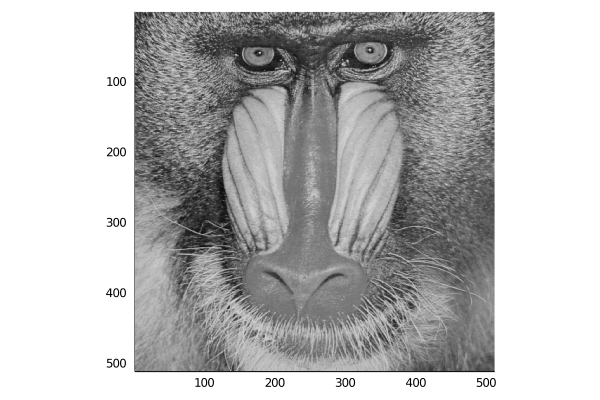

In [4]:
img = testimage("mandrill");
print(size(img))
imgg = Gray.(img);
print(size(imgg))
mat = convert(Array{Float64}, imgg)[1:256,1:512];
# This image is square
plot(imgg)

In [5]:
rows = size(mat,1);
columns = size(mat,2);
BoundaryNodes1 = collect(1:rows);
BoundaryNodes2 = collect(rows+1:rows:rows*columns-rows+1);
BoundaryNodes3 = collect(rows*columns-rows+2:rows*columns);
BoundaryNodes4 = collect(2*rows:rows:(columns-1)*rows);
BoundaryNodes= union(BoundaryNodes1, BoundaryNodes2, BoundaryNodes3, BoundaryNodes4);
AllNodes = collect(1:rows*columns)
NonBoundaryNodes = setdiff(AllNodes, BoundaryNodes);
size(NonBoundaryNodes);

In [6]:
#Now we discard about 50% of the non boundary nodes
No_of_nodes_discarded = 60000
discard = rand(1:length(NonBoundaryNodes), No_of_nodes_discarded);
discard = unique(discard);
discard = NonBoundaryNodes[discard];

In [13]:
#Constructing the 2D Laplace matrix
function spdiagm_nonsquare(m, n, args...)
    I, J, V = SparseArrays.spdiagm_internal(args...)
    return sparse(I, J, V, m, n)
end

# returns -∇² (discrete Laplacian, real-symmetric positive-definite) on n₁×n₂ grid
function ∇²(n₁,n₂)
    o₁ = ones(n₁)
    ∂₁ = spdiagm_nonsquare(n₁+1,n₁,-1=>-o₁,0=>o₁)
    o₂ = ones(n₂)
    ∂₂ = spdiagm_nonsquare(n₂+1,n₂,-1=>-o₂,0=>o₂)
    return kron(sparse(I,n₂,n₂), ∂₁'*∂₁) + kron(∂₂'*∂₂, sparse(I,n₁,n₁))
end



∇² (generic function with 1 method)

In [14]:
A = ∇²(rows,columns);
epsilon = 0.1;
sizeA = size(A,1);
for i = 1:sizeA
    A[i,i] = A[i,i] + epsilon^2
end

In [15]:
#Enforcing Dirichlet Boundary conditions
A[BoundaryNodes,:] .= 0
A[:,BoundaryNodes] .= 0
A[BoundaryNodes, BoundaryNodes] = sparse(I, length(BoundaryNodes), length(BoundaryNodes));
A;
holeyimage1 = mat;
holeyimage1[discard].=1
plot(Gray.(holeyimage1), title="Image with Missing data")
savefig("Mandrill_missing.png")
mat = convert(Array{Float64}, imgg)[1:256,1:512];

In [17]:
#Constructing C
C = sparse(I, rows*columns, rows*columns)
for i in discard
    C[i,i] = 0;
end
#C[discard,discard] .= 0
Id = sparse(I, rows*columns,rows*columns);
f = mat[:];
u =((C-(Id -C)*A)) \ (C*f);
restored_img = reshape(u, size(mat,1), size(mat,2));
plot(Gray.(restored_img), title="Inpainting_Homogeneous_Diffusion")
savefig("Mandrill_Reconstructed.png")

In [18]:
plot(imgg[1:size(mat,1),1:size(mat,2)], title="Original")
savefig("Mandrill_Truth.png")
A_new  = ∇²(rows,columns);
maximum((A_new*u)[discard] .< 1e-6) == length(discard);

In [259]:
maximum((A_new*u)[discard])

-0.0005237132747520218

# Adding holes to the Mandrill Image

In [19]:
cent = [(100, 200), (200, 100), (400, 200)]
c = cent[1]
rad = 20

L = 1:size(mat,1)
K = 1:size(mat,2)

mask = ones(size(mat))
mask = broadcast(+, (L .- c[1]).^2, (K .- c[2])'.^2) .> rad^2

keep = collect(1:prod(size(mat)))

fun(c, k) = filter(x -> (floor(x/size(mat,1)) .- c[1]).^2 + (x%size(mat,1) .- c[2])'.^2 > rad^2, k)

keep = fun(cent[1], keep)
keep = fun(cent[2], keep)
keep = fun(cent[3], keep)

prod(size(mask)) - sum(mask[keep]), 2*20^2*pi;
print(size(keep))

(127301,)

In [20]:
S = [i*size(mat,2)+j for i in 0:(size(mat,1)-1) for j in 1:size(mat,2)]
vals = mat[:]
holeyimage = ones(size(mat,1),size(mat,2))
holeyimage[S[keep]] = vals[keep]
print(size(holeyimage))
plot(Gray.(holeyimage))
savefig("MandrilWithHoles.png")

(256, 512)

In [21]:
discard = setdiff(AllNodes, keep);

In [22]:
using Pkg
Pkg.add("NPZ");

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%                            61.3%                     70.9%#####                 80.6%
  Resolving package versions...
  Installed PlotThemes ───────── v2.0.1
  Installed Missings ─────────── v0.4.5
  Installed EllipsisNotation ─── v1.1.0
  Installed PlotUtils ────────── v1.0.10
  Installed OrderedCollections ─ v1.3.3
  Installed Requires ─────────── v1.1.2
  Installed Latexify ─────────── v0.14.7
  Installed JLLWrappers ──────── v1.2.0
  Installed Adapt ────────────── v3.2.0
  Installed OffsetArrays ─────── v1.5.3
  Installed IfElse ───────────── v0.1.0
  Installed IntervalSets ─────── v0.5.2
  Installed DataStructures ───── v0.18.9
  Installed PaddedViews ──────── v0.5.8
  Installed Tables ───────────── v1.3.2
  Installed libsodium_jll ────── v1.0.18+1
  Installed GeometryBasics ───── v0.3.9
  Installed Zstd_jll ─────────── v1.4.8+0
  Installed StructA

In [26]:
using NPZ

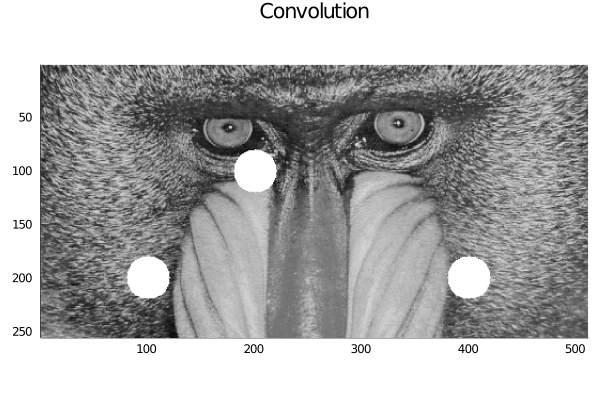

In [28]:
npzwrite("holeyimage.npy", holeyimage)
holeyimage_convolve_restored = npzread("holeyimage_restored.npy")
plot(Gray.(holeyimage), title="Convolution")

In [25]:
A = [1 0 0;
            1 8 7;
            2 9 0] |> sparse;
rowindex = A.rowval[nzrange(A, 2)];
A[rowindex,2] .= 0;
A

3×3 SparseMatrixCSC{Int64,Int64} with 6 stored entries:
  [1, 1]  =  1
  [2, 1]  =  1
  [3, 1]  =  2
  [2, 2]  =  0
  [3, 2]  =  0
  [2, 3]  =  7

In [53]:
using Pkg
Pkg.add("AlgebraicMultigrid")

  Resolving package versions...
  Installed SodiumSeal ───────── v0.1.1
  Installed AlgebraicMultigrid ─ v0.4.0
  Installed IterativeSolvers ─── v0.9.0
  Installed GitHub ───────────── v5.4.0
  Installed CompatHelper ─────── v1.16.3
  Installed TimeZones ────────── v1.5.3
Updating `~/.julia/environments/v1.5/Project.toml`
  [2169fc97] + AlgebraicMultigrid v0.4.0
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [2169fc97] + AlgebraicMultigrid v0.4.0
  [aa819f21] + CompatHelper v1.16.3
  [e2ba6199] + ExprTools v0.1.3
  [8f5d6c58] + EzXML v1.1.0
  [bc5e4493] + GitHub v5.4.0
  [42fd0dbc] + IterativeSolvers v0.9.0
  [78c3b35d] + Mocking v0.7.1
  [2133526b] + SodiumSeal v0.1.1
  [f269a46b] + TimeZones v1.5.3
   Building TimeZones → `~/.julia/packages/TimeZones/K98G0/deps/build.log`


  0.215019 seconds (931.29 k allocations: 195.910 MiB, 7.58% gc time)


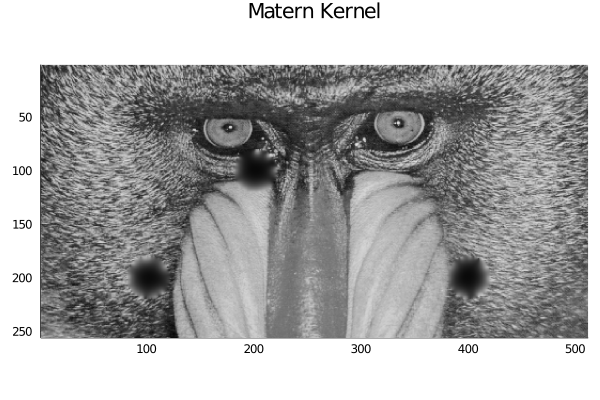

In [92]:
using AlgebraicMultigrid
@time begin
A = ∇²(rows,columns);
epsilon = 0.3;
sizeA = size(A,1);
for i = 1:sizeA
    A[i,i] = A[i,i] + epsilon^2
end
C = sparse(I, rows*columns, rows*columns)
# A[BoundaryNodes,:] .= 0
# A[:,BoundaryNodes] .= 0

# A[BoundaryNodes, BoundaryNodes] = sparse(I, length(BoundaryNodes), length(BoundaryNodes));
# for i in BoundaryNodes
#     rowindices = A.rowval[nzrange(A, i)];
#     A[rowindices,i].=0;
#     A[i,i] = 1.0
# end


for i in discard
    C[i,i] =0.
end
A2 = A*A;
#C[discard,discard] .= 0
Id = sparse(I, rows*columns,rows*columns);
f = mat[:];
u =((C-(Id -C)*A2)) \ (C*f);
# ml = ruge_stuben(((C-(Id -C)*A2)))
# u_amg = solve(ml, (C*f))
restored_img = reshape(u, size(mat,1), size(mat,2));
end
plot(Gray.(restored_img), title="Inpainting_Homogeneous_Diffusion")
GaussianConv2DInterp = npzread("GaussianConvolution2D.npy")
plot1 = plot(Gray.(restored_img), title="Matern Kernel");
plot2 = plot(Gray.(GaussianConv2DInterp), title="Gaussian Interpolation");
plot(plot1) 
#savefig("MandrilWithHolesRestored.png")

In [90]:
save("Mandrill_Holes_Restored_Global.jld", "Mandrill_Holes_Restored_Global", u)
sum((A_new*u)[discard] .< 1e-6) == length(discard)

false

In [26]:
#Constructing the 3D Laplace matrix
function spdiagm_nonsquare(m, n, args...)
    I, J, V = SparseArrays.spdiagm_internal(args...)
    return sparse(I, J, V, m, n)
end

# returns -∇² (discrete Laplacian, real-symmetric positive-definite) on n₁×n₂ grid
function ∇²3d(n₁,n₂,n3)
    o₁ = ones(n₁)
    ∂₁ = spdiagm_nonsquare(n₁+1,n₁,-1=>-o₁,0=>o₁)
    o₂ = ones(n₂)
    ∂₂ = spdiagm_nonsquare(n₂+1,n₂,-1=>-o₂,0=>o₂)
    O3 = ones(n3)
    del3 = spdiagm_nonsquare(n3+1,n3,-1=>-O3,0=>O3)
    return kron(sparse(I,n3,n3),sparse(I,n₂,n₂), ∂₁'*∂₁) + kron(sparse(I,n3,n3), ∂₂'*∂₂, sparse(I,n₁,n₁)) + kron(del3'*del3, sparse(I,n₂,n₂), sparse(I,n₁,n₁))
end

∇²3d (generic function with 1 method)

We will now solve a simple Poisson problem $-\Delta u =  f $ with homogeneous Dirichlet boundary conditions to verify the correctness of our Laplace operator. We will use the method of manufactured solutions with $u = \sin(2 \pi x) \sin(2\pi y) \sin(2\pi z)$.

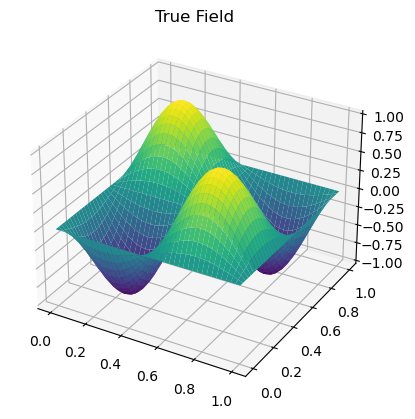

PyObject Text(0.5, 1.0, 'True Field')

In [27]:
using VectorizedRoutines, PyPlot
h = 0.025
x_dir = collect(0:h:1);
y_dir = collect(0:h:1);
z_dir = collect(0:h:1);
xmesh, ymesh, zmesh = Matlab.meshgrid(x_dir, y_dir, z_dir);
u_true = sin.(2*pi*xmesh).*sin.(2*pi*ymesh).*sin.(2*pi*zmesh);
surf(xmesh[:,:,1], ymesh[:,:,1], u_true[:,:,31], cmap=ColorMap("viridis"));
title("True Field")

In [29]:
ngrid = convert(Int64, 1/h+1);
rhs_f = -12*pi^2*sin.(2*pi*xmesh).*sin.(2*pi*ymesh).*sin.(2*pi*zmesh);
rhs_f = rhs_f[:];
A3D = -∇²3d(ngrid, ngrid, ngrid)/h^2;

In [30]:
function return_boundary_nodes(xpoints, ypoints, zpoints)
    BoundaryNodes3D =[];
    counter = 0;
    for k = 1:zpoints
        for j = 1:ypoints
            for i = 1:xpoints
                counter=counter+1;
                if(k == 1 || k == zpoints || j == 1|| j == ypoints || i == 1 || i == xpoints)
                    BoundaryNodes3D = push!(BoundaryNodes3D, counter)
                end
            end
        end
    end
    return BoundaryNodes3D
end
bnodes = return_boundary_nodes(ngrid,ngrid,ngrid);


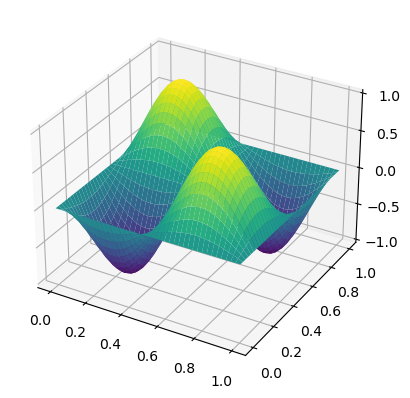

In [31]:
#Enforcing Dirichlet Boundary Conditions:
#Enforcing Dirichlet Boundary conditions
A3D[bnodes,:] .= 0
A3D[:,bnodes] .= 0
A3D[bnodes, bnodes] = sparse(I, length(bnodes), length(bnodes));
u_approx_vector = A3D\rhs_f;
u_approx = reshape(u_approx_vector, ngrid, ngrid, ngrid);
surf(xmesh[:,:,1], ymesh[:,:,1], u_approx[:,:,31], cmap=ColorMap("viridis"));

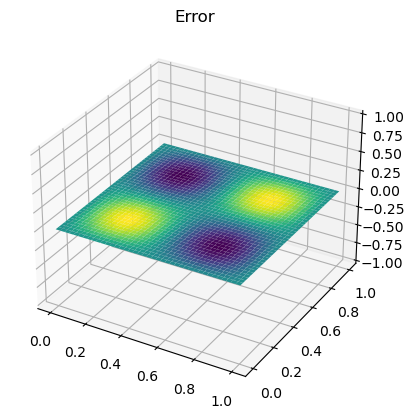

PyObject Text(0.5, 1.0, 'Error')

In [32]:
norm(u_approx[:] - u_true[:])
error = reshape(u_true[:] -u_approx[:], ngrid,ngrid,ngrid);
surf(xmesh[:,:,1], ymesh[:,:,1], error[:,:,31], cmap=ColorMap("viridis"));

zlim([-1,1])
title("Error")

In [33]:
AllNodes3D = collect(1:ngrid*ngrid*ngrid)
NonBoundaryNodes3D = setdiff(AllNodes3D, bnodes);

In [34]:
#Now we discard about 50% of the non boundary nodes
No_of_nodes_discarded = 30000
discard = rand(1:length(NonBoundaryNodes3D), No_of_nodes_discarded);
discard = unique(discard);
discard = NonBoundaryNodes3D[discard];

In [37]:
#Constructing C
C = sparse(I, ngrid*ngrid*ngrid, ngrid*ngrid*ngrid)
for i in discard
    C[i,i] = 0;
end
#C[discard,discard] .= 0
Id = sparse(I, ngrid^3,ngrid^3);
f = u_true[:];
u =((C-(Id -C)*A3D)) \ (C*f);
restored_img = reshape(u, ngrid, ngrid, ngrid);

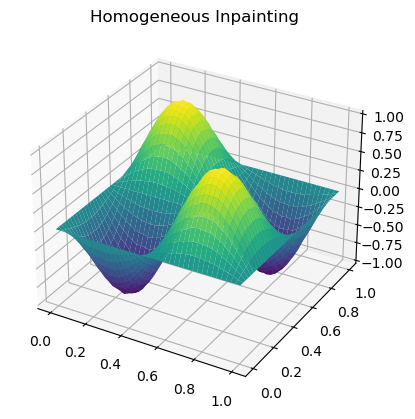

PyObject Text(0.5, 1.0, 'Homogeneous Inpainting')

In [38]:
restored_img = reshape(u, ngrid, ngrid, ngrid);
surf(xmesh[:,:,1], ymesh[:,:,1], restored_img[:,:,31], cmap=ColorMap("viridis"));
zlim([-1,1])
title("Homogeneous Inpainting")

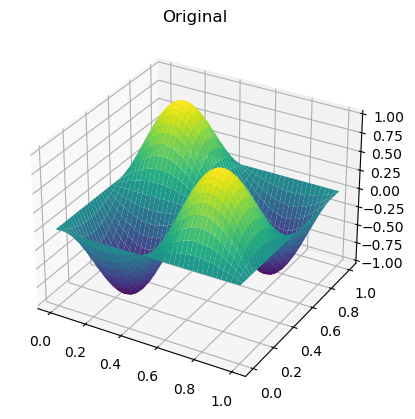

PyObject Text(0.5, 1.0, 'Original')

In [43]:
surf(xmesh[:,:,1], ymesh[:,:,1], u_true[:,:,31], cmap=ColorMap("viridis"))
title("Original")

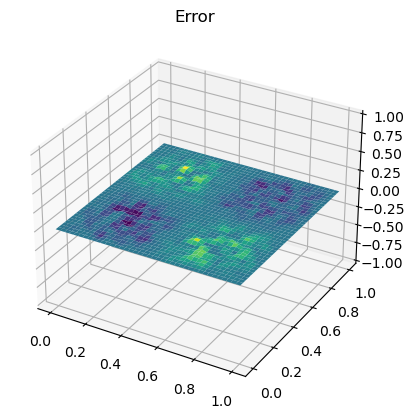

PyObject Text(0.5, 1.0, 'Error')

In [44]:
surf(xmesh[:,:,1], ymesh[:,:,1], (u_true - restored_img)[:,:,31], cmap=ColorMap("viridis"))
zlim([-1,1])
title("Error")

In [45]:
maximum((A3D*u)[discard])

2.2737367544323206e-12

# 3D Giphy Example

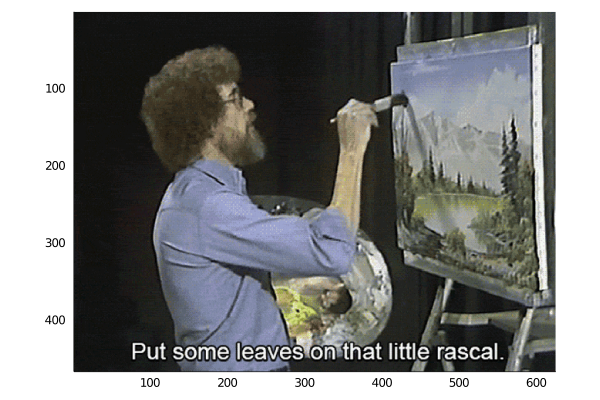

In [222]:
obj = load("/Users/vishwasrao/Research/BES_Project/2020_06_Jun/06112020_Meeting/giphy.gif")

# 14 frames, here is the first one
plot(obj[:,:,1])

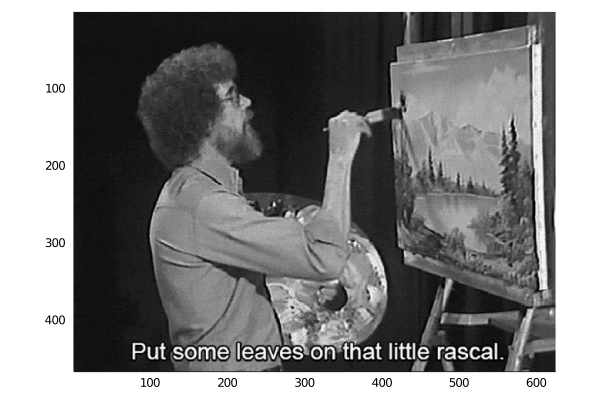

(467, 625, 14)

In [223]:
using GR
GR.inline()
nsteps = 14
imgg = Gray.(obj)
for n = 1:nsteps
    IJulia.clear_output(true)
    plot(imgg[:,:,n])  |> display
end
size(imgg)

In [224]:
AllNodesGiphy = 1:prod(size(imgg));

In [225]:
xpoints = size(imgg, 1);
ypoints = size(imgg, 2);
zpoints = size(imgg, 3);
imgg_temp = reshape(imgg, xpoints*ypoints*zpoints,1);
BoundaryNodesGiphy = return_boundary_nodes(xpoints,ypoints,zpoints);

In [226]:
NonBoundaryNodesGiphy = setdiff(AllNodesGiphy, BoundaryNodesGiphy);
size(NonBoundaryNodesGiphy)

(3476340,)

In [227]:
No_of_nodes_discarded = 3000000;
discard = rand(1:length(NonBoundaryNodesGiphy), No_of_nodes_discarded);
discard = unique(discard);
discard = NonBoundaryNodesGiphy[discard];
holeyimage3D = copy(imgg);
holeyimage3D[discard].=1
npzwrite("imagetemp.npy", Float64.(imgg_temp));
npzwrite("discarded.npy", discard)

In [228]:
@time begin
A3DGiphy = -∇²3d(xpoints, ypoints, zpoints);
for i in BoundaryNodes
    rowindices = A3DGiphy.rowval[nzrange(A3DGiphy, i)];
    A3DGiphy[rowindices,i].=0;
    A3DGiphy[i,i] = 1.0
end
# for i in BoundaryNodes
#     rowindices = A3DGiphy.rowval[nzrange(A, i)];
#     for j in rowindices
#         A3DGiphy[j,i] =0;
#     end
#     A3DGiphy[i,i] = 1.0
# end
#A3DGiphy[BoundaryNodesGiphy, BoundaryNodesGiphy] = sparse(I, length(BoundaryNodesGiphy), length(BoundaryNodesGiphy));

totalsize = prod(size(imgg));
C = sparse(I, totalsize, totalsize)
for i in discard
    C[i,i] = 0;
end
#C[discard,discard] .= 0
Id = sparse(I, totalsize, totalsize);
f = holeyimage3D[:];
C*f
#u =((C-(Id -C)*A3DGiphy)) \ (C*f);
#restored_img = reshape(u, xpoints, ypoints, zpoints);

rhs_a = C*f

rhs_a = Float64.(rhs_a);

u =((C-(Id -C)*A3DGiphy)) \ rhs_a;

restored_img = reshape(u, xpoints, ypoints, zpoints);
restored_img = Gray.(restored_img);
end

 69.833579 seconds (8.19 M allocations: 8.846 GiB, 3.03% gc time)


467×625×14 Array{Gray{Float64},3} with eltype Gray{Float64}:
[:, :, 1] =
 Gray{Float64}(0.0705882)  …  Gray{Float64}(0.25098)
 Gray{Float64}(0.0705882)     Gray{Float64}(0.25098)
 Gray{Float64}(0.0705882)     Gray{Float64}(0.25098)
 Gray{Float64}(0.0705882)     Gray{Float64}(0.207843)
 Gray{Float64}(0.0705882)     Gray{Float64}(0.25098)
 Gray{Float64}(0.0705882)  …  Gray{Float64}(0.215686)
 Gray{Float64}(0.0705882)     Gray{Float64}(0.25098)
 Gray{Float64}(0.0705882)     Gray{Float64}(0.25098)
 Gray{Float64}(0.0705882)     Gray{Float64}(0.215686)
 Gray{Float64}(0.0705882)     Gray{Float64}(0.282353)
 Gray{Float64}(0.0705882)  …  Gray{Float64}(0.215686)
 Gray{Float64}(0.0588235)     Gray{Float64}(0.215686)
 Gray{Float64}(0.0705882)     Gray{Float64}(0.207843)
 ⋮                         ⋱  
 Gray{Float64}(0.0588235)  …  Gray{Float64}(0.113725)
 Gray{Float64}(0.0941176)     Gray{Float64}(0.0941176)
 Gray{Float64}(0.0509804)     Gray{Float64}(0.113725)
 Gray{Float64}(0.0705882)     Gray{Fl

In [1]:
for n = 1:nsteps
    IJulia.clear_output(true)
    plot1 = plot(imgg[:,:,n], title = "Original Image");
    plot2 = plot(restored_img[:,:,n], title = "Restored Image");
    plot(plot1, plot2, layout = (1, 2), legend = false) |>display
end

LoadError: UndefVarError: nsteps not defined